In [5]:
import geopandas as gpd
import pandas as pd
from glob import glob
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [6]:
def ag_func(df):
    d = {}
    d['tasmax'] = df['tasmax'].mean()
    d['tasmin'] = df['tasmin'].mean()
    d['pr'] = df['pr'].sum()
    return pd.Series(d)

def aggregate_by_model(df, model_name, month_range=(6,8), year_range=(2006,2100)):
    query = df.xs(model_name, level='model')
    query = query[(query.index.year >= year_range[0]) & (query.index.year <= year_range[1])]
    query = query[(query.index.month >= month_range[0]) & (query.index.month <= month_range[1])]
    q_agg = query.groupby([query.index.year, \
                           query.index.month]).apply(ag_func)
    q_agg.index.names = ['year', 'month']
    columns = [(f'{model_name}',n) for n in q_agg.columns.values]
    q_agg.columns = pd.MultiIndex.from_tuples(columns)
    return q_agg

def create_gcm_summary(filename):
    #df = pd.read_csv(glob(f'{wd}/*{s}*')[0], chunksize=1e5)
    df = dd.read_csv(filename)
    df['img_date'] = df['img_date'].astype('datetime64')
    df['tasmin'] = df['tasmin'] - 273.15
    df['tasmax'] = df['tasmax'] - 273.15
    df['pr'] = df['pr'] * 86400
    model_list = np.unique(np.array([v[1] for v in groups.index.values]))
    df_summary = pd.concat([aggregate_by_model(groups, model) for model in model_list],\
                       axis=1).dropna()
    df_summary.columns.names = ['model', 'scenario']
    return df_summary

# 10 Percentile
def qlower(x):
            return x.quantile(0.1)

# 90 Percentile
def qupper(x):
            return x.quantile(0.9)
 

In [3]:
#BUCKET = 'ikh-nart'
BUCKET = 'rio-mora'
rcp = 85
if BUCKET=='ikh-nart':
    alias = 'wdpa-99848'
    plot_month_range = (6,10)
else:
    alias = 'wdpa-555609346'
    plot_month_range = (4,10)
datadir = f'/datadrive/{BUCKET}/data/{alias}/'
points = pd.read_csv(f'{datadir}/{alias}_points_v1.csv')
gcmfile = f'{datadir}/GDDP_rcp{rcp}_{alias}_v1.csv' 

scenario_list = ['rcp45', 'rcp85']
s = scenario_list[0]
#df = pd.read_csv(glob(f'{wd}/*{s}*')[0], chunksize=1e5)
#df = dd.read_csv(glob(f'{wd}/*{s}*')[0])
df = dd.read_csv(gcmfile)
df['img_date'] = df['img_date'].astype('datetime64')
df['tasmin'] = df['tasmin'] - 273.15
df['tasmax'] = df['tasmax'] - 273.15
df['pr'] = df['pr'] * 86400
groups = df.groupby(['img_date','model'])['tasmax','tasmin','pr'].mean().compute()
#get the list of model names
model_list = np.unique(np.array([v[1] for v in groups.index.values]))
#execute summary
seasonal_months = {'JFM':(1,3),'AMJ':(4,6),'JAS':(7,9),'OND':(10,12)}
df_seasonal = {}

for season,month_range in seasonal_months.items():
    #take the mean of all the points 
    df_summary = pd.concat([aggregate_by_model(groups, model, month_range) for model in model_list],\
                           axis=1).dropna()
    df_summary.columns.names = ['model', 'climate']
    df_seasonal[season] = df_summary.copy()

df_summary = pd.concat([aggregate_by_model(groups, model, plot_month_range) for model in model_list],\
                       axis=1).dropna()
df_summary.columns.names = ['model', 'climate']
climate_vars = df_summary.columns.levels[-1].values

#df_summary.to_csv(f'{wd}/GDDP_processed.csv')

/usr/local/lib/python3.6/dist-packages/dask/dataframe/groupby.py:1738: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g._meta = g._meta[key]


In [9]:
#generate a plot of the climate and time series of region
import rasterio
terradata = {}
BUCKETS = ['ikh-nart', 'rio-mora']
for BUCKET in BUCKETS:
    region_data = {} 
    ####NDVI DATA PREP####
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/TERRA_AMJ.tif')
    terra = tif.read()
    if BUCKET == 'ikh-nart':
        shp = './data/shp/IN_boundary/IN_boundary.shp'
        figsize = (20,12)
        n_clusters = 3
    else:
        shp = './data/shp/RioMoraNWRBndry_2019/RioMoraNWRBndry_2019.shp'
        figsize = (20,7)
        n_clusters = 3
    labels = ['Precipitation', '$T_{max}$', '$T_{min}$']
    unit = ['(mm)', '$(^oC)$', '$(^oC)$']
    selection =['pr','x','n']
    v = ['pr', 'tasmax', 'tasmin']
    for n in range(len(selection)):
        var = selection[n]
        cindex = [(i+1,b) for i,b in enumerate(tif.descriptions) \
                  if any(s in b for s in var)]
        data = np.array([tif.read(c[0]) for c in cindex])
        if var == 'pr':
            scale = 1
        else:
            scale = 0.1
        data = scale*data
        region_data[v[n]] = np.nanmean(data,axis=(1,2))
    terradata[BUCKET] = region_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_width" which is no longer supported as of 3.3 and will become an error two minor releases later


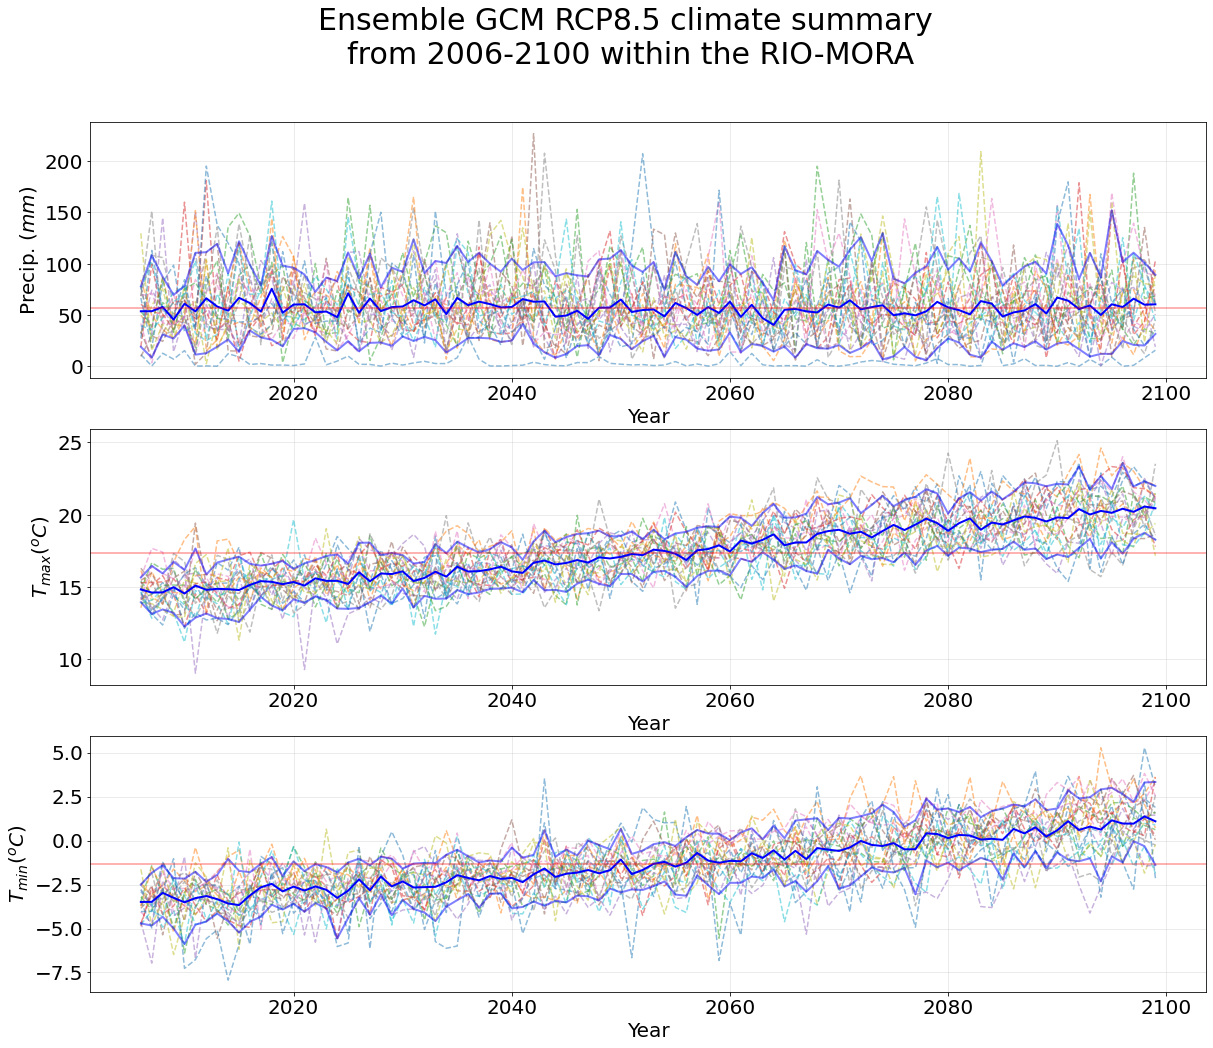

In [12]:
#plot time series

f, ax = plt.subplots(len(climate_vars),1,figsize=(20,16))
var_labels = {'pr':'Precip. ($mm$)', \
              'tasmax':'$T_{max}$($^oC$)', \
              'tasmin':'$T_{min}$($^oC$)'}
for i, var in enumerate(climate_vars):
    if var == 'pr':
        summary = df_summary.groupby('year').agg('sum').xs(var, level='climate', axis=1)
    else:
        summary = df_summary.groupby('year').agg('mean').xs(var, level='climate', axis=1)
    summary.plot(ax=ax[i], ls='--',alpha=0.5, legend=False)
    gcm_mean = summary.agg('mean', axis=1)
    gcm_mean.plot(ax=ax[i], lw=2, color='blue')
    gcm_lower = summary.agg(qlower, axis=1)
    gcm_lower.plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    gcm_upper = summary.agg(qupper, axis=1)
    gcm_upper.plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    ax[i].axhline(gcm_mean.mean(), color='red', alpha=0.3, lw=2)
    ax[i].grid(alpha=0.3)
    ax[i].set_ylabel(var_labels[var], fontsize=20)
    ax[i].set_xlabel('Year',fontsize=20)
#    ax[i].set_xticklabels(fontsize=20)
#    ax[i].set_yticklabels(fontsize=20)
    ax[i].tick_params(axis='both', labelsize=20)
f.suptitle(f'Ensemble GCM RCP8.5 climate summary \nfrom 2006-2100 within the {BUCKET.upper()}',\
          fontsize=30)
f.savefig(f'./figs/{BUCKET}_gcmseries.png',dpi=300,bbox_width='tight')


In [10]:
terradata

{'ikh-nart': {'pr': array([159.88022 , 145.46059 , 114.707924,  68.77382 , 139.50323 ,
         112.1406  , 103.79559 , 147.1631  , 147.89394 , 120.15878 ,
         104.01788 , 130.0575  , 155.187   ,  91.75286 ,  83.23268 ,
          87.84871 ,  64.298134, 114.35846 ,  55.564777,  54.758194,
          74.50588 ,  62.61385 ,  99.5179  ,  83.27678 ,  69.76171 ,
         100.15246 , 107.40045 , 110.02522 ,  76.41343 ,  70.59389 ,
         131.45488 ,  88.428375, 158.69907 ,  80.99954 ], dtype=float32),
  'tasmax': array([20.032318, 19.816055, 21.568287, 20.767311, 20.586395, 21.56012 ,
         20.43866 , 20.55282 , 20.843382, 21.494932, 20.183222, 21.067898,
         21.24101 , 21.651537, 22.001745, 21.933378, 21.35513 , 21.083961,
         21.8901  , 22.721823, 22.409637, 23.276405, 22.429363, 21.721016,
         22.847328, 22.060823, 20.71787 , 21.98488 , 21.921919, 22.216381,
         22.30175 , 22.750774, 21.71464 , 23.098236], dtype=float32),
  'tasmin': array([ 7.9710765,  7.31367

In [35]:

ss =  summary.agg(['mean','std'], axis=1)

In [38]:
ss.mean


<bound method DataFrame.mean of           mean       std
2006 -3.490544  0.870917
2007 -3.485042  1.259691
2008 -2.972026  1.174235
2009 -3.254484  1.285751
2010 -3.509019  1.526300
...        ...       ...
2095  1.150640  1.465490
2096  0.969935  1.481888
2097  0.961199  1.505713
2098  1.371335  1.686028
2099  1.094718  1.701736

[94 rows x 2 columns]>

In [42]:
#print in LaTeX table style
climate_vars = df_summary.columns.levels[-1].values
seasonal_avgs = {v:{} for v in climate_vars}
seasonal_stds = {v:{} for v in climate_vars}
trends = {v:{} for v in climate_vars}
for season,df_summary in df_seasonal.items():
    for i, var in enumerate(climate_vars):
        if var == 'pr':
            summary = df_summary.groupby('year').agg('sum').xs(var, level='climate', axis=1)
        else:
            summary = df_summary.groupby('year').agg('mean').xs(var, level='climate', axis=1)
        season_aggregate = summary.agg(['mean','std'], axis=1)
        seasonal_avgs[var][season],seasonal_stds[var][season] = season_aggregate['mean'], season_aggregate['std']
        
        reg = linear_model.LinearRegression()
        y = season_aggregate['mean'].values
        X = np.array(season_aggregate.index).reshape(-1,1)
        #X = np.arange(len(y)).reshape(-1,1)
        result = reg.fit(X,y)
        trends[var][season] = result.coef_
labels = ['Cumulative Precip. ($\\frac{mm}{years_{100}}$)',\
          'Mean $T_{max}$ ($\\frac{^oC}{years_{100}}$)', \
          'Mean $T_{min}$ ($\\frac{^oC}{years_{100}}$)']
print('\\begin{table}[h]')
print('\\centering')
print('\\begin{tabular}{lllll}')
print('\\toprule')
print('&', end='')
for k,_ in seasonal_months.items():
    print('\\textbf{%s} & '%k, end='')
print('\\\\')
for l,(_,v) in zip(labels,trends.items()):
    print('\\textbf{%s} & '%l, end='')
    for _,v in v.items():
        print('%0.2f & '%(v*100), end='')
    print('\\\\')
print('\\bottomrule')
print('\\end{tabular}')
print('\\caption{}')
print('\\end{table}')


\begin{table}[h]
\centering
\begin{tabular}{lllll}
\toprule
&\textbf{JFM} & \textbf{AMJ} & \textbf{JAS} & \textbf{OND} & \\
\textbf{Cumulative Precip. ($\frac{mm}{years_{100}}$)} & 2.85 & -12.35 & -20.04 & -1.74 & \\
\textbf{Mean $T_{max}$ ($\frac{^oC}{years_{100}}$)} & 5.64 & 6.93 & 6.90 & 6.60 & \\
\textbf{Mean $T_{min}$ ($\frac{^oC}{years_{100}}$)} & 4.24 & 5.32 & 6.27 & 5.02 & \\
\bottomrule
\end{tabular}
\caption{}
\end{table}


In [9]:
#generate a plot of the climate and time series of region
import rasterio
terradata = {}
BUCKETS = ['ikh-nart', 'rio-mora']
for BUCKET in BUCKETS:
    region_data = {} 
    ####NDVI DATA PREP####
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/TERRA_AMJ.tif')
    terra = tif.read()
    if BUCKET == 'ikh-nart':
        shp = './data/shp/IN_boundary/IN_boundary.shp'
        figsize = (20,12)
        n_clusters = 3
    else:
        shp = './data/shp/RioMoraNWRBndry_2019/RioMoraNWRBndry_2019.shp'
        figsize = (20,7)
        n_clusters = 3
    labels = ['Precipitation', '$T_{max}$', '$T_{min}$']
    unit = ['(mm)', '$(^oC)$', '$(^oC)$']
    selection =['pr','x','n']
    v = ['pr', 'tasmax', 'tasmin']
    for n in range(len(selection)):
        var = selection[n]
        cindex = [(i+1,b) for i,b in enumerate(tif.descriptions) \
                  if any(s in b for s in var)]
        data = np.array([tif.read(c[0]) for c in cindex])
        if var == 'pr':
            scale = 1
        else:
            scale = 0.1
        data = scale*data
        region_data[v[n]] = np.nanmean(data,axis=(1,2))
    terradata[BUCKET] = region_data

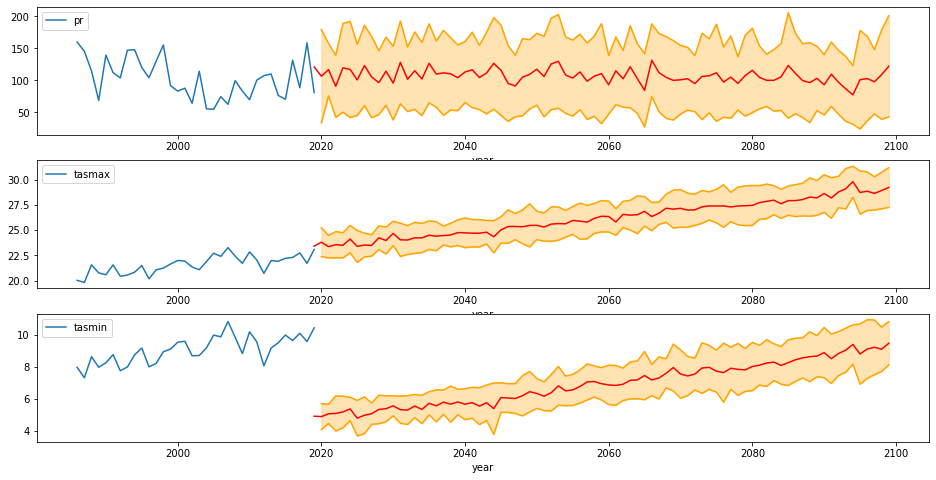

In [66]:
vvv = ['pr','tasmax','tasmin']
f, ax = plt.subplots(3,1, figsize=(16,8))
for i,vv in enumerate(vvv):
    terra_avg = pd.DataFrame({'year':np.arange(1986,2020),vv:terradata['ikh-nart'][vv]})
    terra_avg = terra_avg.set_index('year')

    gcmout = seasonal_avgs[vv]['AMJ'].copy()
    gcmstd = seasonal_stds[vv]['AMJ'].copy()
    lo = gcmout-gcmstd
    hi = gcmout+gcmstd

    terra_avg.plot(ax=ax[i])
    gcmout[gcmout.index>=2019].plot(ax=ax[i], color='red')
    X = lo.index[lo.index>2019]
    lop = lo[lo.index>2019]#.plot(ax=ax, color='orange')
    hop = hi[hi.index>2019]#.plot(ax=ax, color='orange')
    lop.plot(ax=ax[i], color='orange')
    hop.plot(ax=ax[i], color='orange')
    ax[i].fill_between(X, lop, hop, color='orange', alpha=0.3)
    #(gcmout[gcmout.index>2019]-gcmstd[gcmstd.index>2019]).plot(ax=ax)

In [ ]:
#now apply the historic record of climate for the region
#aggregated rate of change by season (3month) by region

In [ ]:
#do a for loop within each model
#generate a new master list that is an aggregate by model
#plot these over time
#repeat for Rio-Mora